Install dependencies

In [127]:
#pip install mediapipe scikit-learn tensorflow opencv-python matplotlib

In [24]:
#!pip list

In [43]:
import cv2
import numpy as np
from matplotlib import pyplot as plt
import time
import tensorflow as tf
import os
import mediapipe as mp

In [44]:
mp_holistic = mp.solutions.holistic     #Holistic model
mp_drawing = mp.solutions.drawing_utils #Drawing utilities

In [45]:
def mediapipe_detection(image,model):
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) # Color conversion
    image.flags.writeable = False
    results = model.process(image)                 # Prediction
    image.flags.writeable = True
    image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR) # Color reversion
    return image,results

In [46]:
#Draw faces,pose and hand connections
def draw_landmarks(image, results):
    mp_drawing.draw_landmarks(image, results.face_landmarks, mp_holistic.FACEMESH_CONTOURS)
    mp_drawing.draw_landmarks(image, results.pose_landmarks, mp_holistic.POSE_CONNECTIONS)
    mp_drawing.draw_landmarks(image, results.left_hand_landmarks, mp_holistic.HAND_CONNECTIONS)
    mp_drawing.draw_landmarks(image, results.right_hand_landmarks, mp_holistic.HAND_CONNECTIONS)
    

In [47]:
def draw_styled_landmarks(image, results):
    mp_drawing.draw_landmarks(image, results.face_landmarks, mp_holistic.FACEMESH_CONTOURS,
                                mp_drawing.DrawingSpec(color=(204, 0, 204), thickness=1, circle_radius=1),
                                mp_drawing.DrawingSpec(color=(51, 153, 0), thickness=1, circle_radius=1))
    mp_drawing.draw_landmarks(image, results.pose_landmarks, mp_holistic.POSE_CONNECTIONS,
                                mp_drawing.DrawingSpec(color=(204, 0, 204), thickness=1, circle_radius=1),
                                mp_drawing.DrawingSpec(color=(51, 153, 0), thickness=1, circle_radius=1))
    mp_drawing.draw_landmarks(image, results.left_hand_landmarks, mp_holistic.HAND_CONNECTIONS,
                                mp_drawing.DrawingSpec(color=(204, 0, 204), thickness=1, circle_radius=1),
                                mp_drawing.DrawingSpec(color=(51, 153, 0), thickness=1, circle_radius=1))
    mp_drawing.draw_landmarks(image, results.right_hand_landmarks, mp_holistic.HAND_CONNECTIONS,
                                mp_drawing.DrawingSpec(color=(204, 0, 204), thickness=1, circle_radius=1),
                                mp_drawing.DrawingSpec(color=(51, 153, 0), thickness=1, circle_radius=1))

In [48]:
cap = cv2.VideoCapture(0)

#Set mediapipe model
with mp_holistic.Holistic(min_detection_confidence=0.5, min_tracking_confidence=0.5) as holistic:
    while cap.isOpened():

        # Read feed
        ret, frame = cap.read()

        # Make detections
        image, results = mediapipe_detection(frame, holistic)
        
        # Draw landmarks
        draw_styled_landmarks(image, results)        

        # Show to screen
        cv2.imshow('OpenCV Feed', image)

        #Break loop
        if cv2.waitKey(10) & 0xFF == ord('q'):
            break
    cap.release()
    cv2.destroyAllWindows()

In [49]:
len(results.pose_landmarks.landmark)

33

In [50]:
draw_styled_landmarks(frame, results)

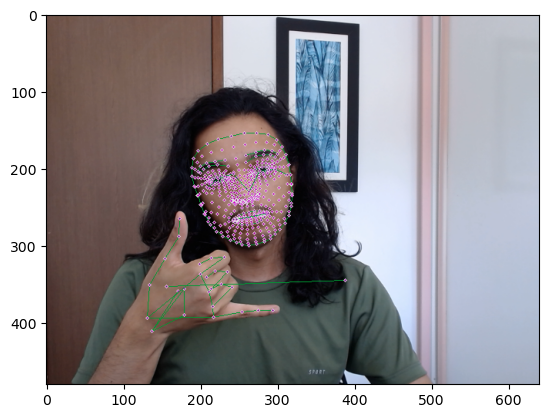

In [51]:
plt.imshow(cv2.cvtColor(frame,cv2.COLOR_BGR2RGB))

In [52]:
def extract_keypoints(results):
    pose = np.array([[res.x, res.y, res.z, res.visibility] for res in results.pose_landmarks.landmark]).flatten() if results.pose_landmarks else np.zeros(33*4)
    face = np.array([[res.x, res.y, res.z] for res in results.face_landmarks.landmark]).flatten() if results.face_landmarks else np.zeros(468*3)
    leftHand = np.array([[res.x, res.y, res.z] for res in results.left_hand_landmarks.landmark]).flatten() if results.left_hand_landmarks else np.zeros(21*3)
    rightHand = np.array([[res.x, res.y, res.z] for res in results.right_hand_landmarks.landmark]).flatten() if results.right_hand_landmarks else np.zeros(21*3)
    return np.concatenate([pose,face,leftHand,rightHand])

In [53]:
result_test = extract_keypoints(results) #Checking results

In [54]:
result_test

array([ 0.41153151,  0.48109832, -0.72435081, ...,  0.46011156,
        0.80031699, -0.02390983])

In [55]:
np.save('0',result_test)

In [92]:
# Path for exported data, numpy arrays
DATA_PATH = os.path.join('MP_DATA')

# Actions that we try to detect
actions = np.array(['Ola', 'Obrigado','EuTeAmo'])

# Thirty videos worth of data
no_sequences = 30

# Size in frames per video
sequence_length = 30


In [75]:
for action in actions: 
    for sequence in range(no_sequences):
        try: 
            os.makedirs(os.path.join(DATA_PATH, action, str(sequence)))
        except:
            pass

In [76]:
cap = cv2.VideoCapture(0)

#Set mediapipe model
with mp_holistic.Holistic(min_detection_confidence=0.5, min_tracking_confidence=0.5) as holistic:
    while cap.isOpened():
        
        #loop through actions
        for action in actions:
            for sequence in range (no_sequences):
                #Loop through video length
                for frame_num in range(sequence_length):                    

                    # Read feed
                    ret, frame = cap.read()
                    
                    # Make detections
                    image, results = mediapipe_detection(frame, holistic)

                    # Draw landmarks
                    draw_styled_landmarks(image, results)                   
                    
                    if frame_num == 0:
                        #Modelling format
                        cv2.putText(image, 'Iniciando Coleta', (120,200),
                                   cv2.FONT_HERSHEY_SIMPLEX, 1 , (0,255,124),2,cv2.LINE_AA)
                        cv2.putText(image, 'Coletando {} frames para o video {}'.format(action,sequence), (15,12),
                                   cv2.FONT_HERSHEY_SIMPLEX, 0.5 , (0,255,0),1,cv2.LINE_AA)
                        
                        cv2.imshow('OpenCV Feed', image)
                        #Wait time of half second
                        cv2.waitKey(500)
                        
                    else:
                        cv2.putText(image, 'Coletando frames para {} Video Num: {}'.format(action,sequence), (15,12),
                                   cv2.FONT_HERSHEY_SIMPLEX, 0.5 , (0,255,0),1,cv2.LINE_AA)
                        #Showing the results
                        cv2.imshow('OpenCV Feed',image)
                    
                    #Save data on folders
                    keypoints = extract_keypoints(results)
                    npy_path = os.path.join(DATA_PATH, action,str(sequence),str(frame_num))
                    np.save(npy_path, keypoints)

                    #Break loop
                    if cv2.waitKey(10) & 0xFF == ord('q'):
                        break
    cap.release()
    cv2.destroyAllWindows()

KeyboardInterrupt: 

In [77]:
cap.release()
cv2.destroyAllWindows()

In [78]:
#!pip install -U scikit-learn
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical


In [95]:
label_map = {label:num for num,label in enumerate(actions)}

In [96]:
label_map

{'Ola': 0, 'Obrigado': 1, 'EuTeAmo': 2}

In [97]:
sequences, labels = [], []
for action in actions:
    for sequence in np.array(os.listdir(os.path.join(DATA_PATH, action))).astype(int):
        window = []
        for frame_num in range(sequence_length):
            res = np.load(os.path.join(DATA_PATH, action, str(sequence), "{}.npy".format(frame_num)))
            window.append(res)
        sequences.append(window)
        labels.append(label_map[action])

In [98]:
np.array(sequences).shape

(90, 30, 1662)

In [99]:
X = np.array(sequences)

In [100]:
X.shape

(90, 30, 1662)

In [101]:
y = to_categorical(labels).astype(int)

In [102]:
X_train, X_test, y_train , y_test = train_test_split(X,y,test_size=0.05)

In [103]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Input
from tensorflow.keras.callbacks import TensorBoard

In [104]:
log_dir = os.path.join('Logs')
tb_callback = TensorBoard(log_dir = log_dir)

In [109]:
model = Sequential()

model.add(Input(shape=(30,1662)))
#model.add(LSTM(64, return_sequences=True, activation='relu', Input(30,1662)))
#model.add(LSTM(64, return_sequences=True, activation='relu'))
model.add(LSTM(128, return_sequences=True, activation='relu'))
model.add(LSTM(64, return_sequences=False, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(32,activation='relu'))
model.add(Dense(actions.shape[0], activation='softmax'))


In [110]:
# The loss function that I use is categorical_crossentropy cause is a multiclass classification model unlike the binary loss function
model.compile(optimizer='Adam', loss='categorical_crossentropy' , metrics=['categorical_accuracy'])

In [112]:
model.fit(X_train, y_train, epochs=1842, callbacks=[tb_callback])

Epoch 1/1842
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - categorical_accuracy: 0.5695 - loss: 0.8540
Epoch 2/1842
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - categorical_accuracy: 0.5930 - loss: 0.9460
Epoch 3/1842
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - categorical_accuracy: 0.6673 - loss: 0.7519
Epoch 4/1842
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - categorical_accuracy: 0.6536 - loss: 0.7718
Epoch 5/1842
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - categorical_accuracy: 0.5520 - loss: 0.8239
Epoch 6/1842
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - categorical_accuracy: 0.5910 - loss: 0.7990
Epoch 7/1842
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - categorical_accuracy: 0.5284 - loss: 0.9935
Epoch 8/1842
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - categorical_accuracy: 0.4774 - loss: 1.0644
Epoch 9/1842
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - categorical_accuracy: 0.4892 - loss: 1.1594
Epoch 10/1842
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - categorical_accuracy: 0.4129 - loss: 1.1686
Epoch 11/1842
3/3 ━━━━━━━━━━━

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - categorical_accuracy: 0.4031 - loss: 1.1548
Epoch 64/1842
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - categorical_accuracy: 0.5147 - loss: 1.0709
Epoch 65/1842
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - categorical_accuracy: 0.4090 - loss: 1.0176
Epoch 66/1842
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - categorical_accuracy: 0.4363 - loss: 1.1012
Epoch 67/1842
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - categorical_accuracy: 0.5675 - loss: 0.9948
Epoch 68/1842
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - categorical_accuracy: 0.3739 - loss: 0.9806
Epoch 69/1842
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - categorical_accuracy: 0.6008 - loss: 0.8948
Epoch 70/1842
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - categorical_accuracy: 0.5754 - loss: 0.9129
Epoch 71/1842
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - categorical_accuracy: 0.4403 - loss: 1.1006
Epoch 72/1842
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - categorical_accuracy: 0.6262 - loss: 0.8349
Epoch 73/1842
3/3 ━━━━━━━━━━━━━━━━

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - categorical_accuracy: 0.4032 - loss: 1.2708
Epoch 125/1842
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - categorical_accuracy: 0.3816 - loss: 1.0684
Epoch 126/1842
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - categorical_accuracy: 0.4345 - loss: 1.0737
Epoch 127/1842
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - categorical_accuracy: 0.7063 - loss: 0.7360
Epoch 128/1842
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - categorical_accuracy: 0.6066 - loss: 0.8941
Epoch 129/1842
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - categorical_accuracy: 0.4794 - loss: 1.0084
Epoch 130/1842
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - categorical_accuracy: 0.5636 - loss: 0.8589
Epoch 131/1842
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - categorical_accuracy: 0.4932 - loss: 0.9975
Epoch 132/1842
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - categorical_accuracy: 0.5870 - loss: 0.8754
Epoch 133/1842
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - categorical_accuracy: 0.4697 - loss: 1.0776
Epoch 134/1842
3/3 ━━━━━━

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - categorical_accuracy: 0.5068 - loss: 1.0394
Epoch 186/1842
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - categorical_accuracy: 0.4423 - loss: 1.2473
Epoch 187/1842
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - categorical_accuracy: 0.4443 - loss: 1.0992
Epoch 188/1842
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - categorical_accuracy: 0.5088 - loss: 1.1371
Epoch 189/1842
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - categorical_accuracy: 0.5831 - loss: 0.8265
Epoch 190/1842
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - categorical_accuracy: 0.5617 - loss: 0.8328
Epoch 191/1842
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - categorical_accuracy: 0.6027 - loss: 0.9405
Epoch 192/1842
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - categorical_accuracy: 0.5421 - loss: 0.8707
Epoch 193/1842
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step - categorical_accuracy: 0.5675 - loss: 0.8368
Epoch 194/1842
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - categorical_accuracy: 0.6496 - loss: 0.7726
Epoch 195/1842
3/3 ━━━━━━

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - categorical_accuracy: 0.4873 - loss: 0.9747
Epoch 247/1842
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - categorical_accuracy: 0.6007 - loss: 0.8090
Epoch 248/1842
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - categorical_accuracy: 0.5420 - loss: 0.9831
Epoch 249/1842
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - categorical_accuracy: 0.5460 - loss: 0.9440
Epoch 250/1842
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - categorical_accuracy: 0.4757 - loss: 1.0351
Epoch 251/1842
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - categorical_accuracy: 0.5303 - loss: 0.9329
Epoch 252/1842
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - categorical_accuracy: 0.6281 - loss: 0.8272
Epoch 253/1842
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - categorical_accuracy: 0.6165 - loss: 0.8644
Epoch 254/1842
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - categorical_accuracy: 0.6086 - loss: 0.7995
Epoch 255/1842
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - categorical_accuracy: 0.7613 - loss: 0.6923
Epoch 256/1842
3/3 ━━━━━━

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - categorical_accuracy: 0.6203 - loss: 0.7418
Epoch 308/1842
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - categorical_accuracy: 0.6302 - loss: 0.7899
Epoch 309/1842
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - categorical_accuracy: 0.6067 - loss: 0.7869
Epoch 310/1842
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - categorical_accuracy: 0.6693 - loss: 0.6664
Epoch 311/1842
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - categorical_accuracy: 0.6419 - loss: 0.7496
Epoch 312/1842
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - categorical_accuracy: 0.5851 - loss: 0.7709
Epoch 313/1842
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - categorical_accuracy: 0.6888 - loss: 0.7281
Epoch 314/1842
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - categorical_accuracy: 0.5342 - loss: 0.8329
Epoch 315/1842
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - categorical_accuracy: 0.6086 - loss: 0.8730
Epoch 316/1842
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - categorical_accuracy: 0.6222 - loss: 0.7940
Epoch 317/1842
3/3 ━━━━━━

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - categorical_accuracy: 0.5010 - loss: 1.0194
Epoch 369/1842
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - categorical_accuracy: 0.5773 - loss: 0.8025
Epoch 370/1842
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - categorical_accuracy: 0.5930 - loss: 0.7174
Epoch 371/1842
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - categorical_accuracy: 0.6027 - loss: 0.7313
Epoch 372/1842
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - categorical_accuracy: 0.5676 - loss: 0.7731
Epoch 373/1842
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - categorical_accuracy: 0.5813 - loss: 0.7848
Epoch 374/1842
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - categorical_accuracy: 0.7006 - loss: 0.6401
Epoch 375/1842
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - categorical_accuracy: 0.5852 - loss: 0.7221
Epoch 376/1842
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - categorical_accuracy: 0.5382 - loss: 1.0406
Epoch 377/1842
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - categorical_accuracy: 0.6888 - loss: 0.6682
Epoch 378/1842
3/3 ━━━━━━

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - categorical_accuracy: 0.5342 - loss: 1.0824
Epoch 430/1842
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - categorical_accuracy: 0.6125 - loss: 0.8288
Epoch 431/1842
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - categorical_accuracy: 0.5909 - loss: 0.8082
Epoch 432/1842
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - categorical_accuracy: 0.4677 - loss: 0.9789
Epoch 433/1842
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - categorical_accuracy: 0.5636 - loss: 0.9537
Epoch 434/1842
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - categorical_accuracy: 0.6204 - loss: 0.8068
Epoch 435/1842
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - categorical_accuracy: 0.4815 - loss: 0.9255
Epoch 436/1842
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - categorical_accuracy: 0.6242 - loss: 0.8913
Epoch 437/1842
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - categorical_accuracy: 0.5734 - loss: 0.8826
Epoch 438/1842
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - categorical_accuracy: 0.5733 - loss: 0.9324
Epoch 439/1842
3/3 ━━━━━━

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - categorical_accuracy: 0.5890 - loss: 0.7015
Epoch 491/1842
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - categorical_accuracy: 0.6653 - loss: 0.7150
Epoch 492/1842
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - categorical_accuracy: 0.6360 - loss: 0.6589
Epoch 493/1842
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - categorical_accuracy: 0.6184 - loss: 0.6986
Epoch 494/1842
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - categorical_accuracy: 0.6791 - loss: 0.6727
Epoch 495/1842
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step - categorical_accuracy: 0.6634 - loss: 0.6476
Epoch 496/1842
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - categorical_accuracy: 0.6438 - loss: 0.7161
Epoch 497/1842
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - categorical_accuracy: 0.7573 - loss: 0.6049
Epoch 498/1842
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - categorical_accuracy: 0.6262 - loss: 0.6782
Epoch 499/1842
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - categorical_accuracy: 0.6575 - loss: 0.6579
Epoch 500/1842
3/3 ━━━━━

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - categorical_accuracy: 0.6223 - loss: 0.7504
Epoch 552/1842
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - categorical_accuracy: 0.6438 - loss: 0.7457
Epoch 553/1842
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - categorical_accuracy: 0.5596 - loss: 0.8951
Epoch 554/1842
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - categorical_accuracy: 0.4483 - loss: 1.0496
Epoch 555/1842
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - categorical_accuracy: 0.5402 - loss: 1.0584
Epoch 556/1842
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - categorical_accuracy: 0.5909 - loss: 0.8369
Epoch 557/1842
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - categorical_accuracy: 0.4716 - loss: 0.8331
Epoch 558/1842
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - categorical_accuracy: 0.6145 - loss: 0.7382
Epoch 559/1842
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - categorical_accuracy: 0.6086 - loss: 0.7627
Epoch 560/1842
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - categorical_accuracy: 0.6536 - loss: 0.7460
Epoch 561/1842
3/3 ━━━━━━

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - categorical_accuracy: 0.6536 - loss: 0.6584
Epoch 613/1842
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - categorical_accuracy: 0.6106 - loss: 0.7415
Epoch 614/1842
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - categorical_accuracy: 0.5363 - loss: 0.8352
Epoch 615/1842
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - categorical_accuracy: 0.6498 - loss: 0.7170
Epoch 616/1842
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - categorical_accuracy: 0.6791 - loss: 0.7196
Epoch 617/1842
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - categorical_accuracy: 0.5441 - loss: 0.8915
Epoch 618/1842
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - categorical_accuracy: 0.6399 - loss: 0.6751
Epoch 619/1842
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - categorical_accuracy: 0.6907 - loss: 0.6538
Epoch 620/1842
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - categorical_accuracy: 0.6400 - loss: 0.6923
Epoch 621/1842
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - categorical_accuracy: 0.6106 - loss: 0.7164
Epoch 622/1842
3/3 ━━━━━━

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step - categorical_accuracy: 0.6614 - loss: 0.6758
Epoch 674/1842
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - categorical_accuracy: 0.6536 - loss: 0.6504
Epoch 675/1842
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - categorical_accuracy: 0.6849 - loss: 0.6827
Epoch 676/1842
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - categorical_accuracy: 0.6927 - loss: 0.6443
Epoch 677/1842
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - categorical_accuracy: 0.6595 - loss: 0.6505
Epoch 678/1842
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 650ms/step - categorical_accuracy: 0.6222 - loss: 0.7315
Epoch 679/1842
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - categorical_accuracy: 0.5636 - loss: 0.7960
Epoch 680/1842
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - categorical_accuracy: 0.5890 - loss: 0.7708
Epoch 681/1842
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - categorical_accuracy: 0.5949 - loss: 0.7341
Epoch 682/1842
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - categorical_accuracy: 0.5382 - loss: 0.9458
Epoch 683/1842
3/3 ━━━━

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - categorical_accuracy: 0.6888 - loss: 0.6362
Epoch 735/1842
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - categorical_accuracy: 0.6712 - loss: 0.6480
Epoch 736/1842
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - categorical_accuracy: 0.6321 - loss: 0.6626
Epoch 737/1842
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - categorical_accuracy: 0.5793 - loss: 0.6988
Epoch 738/1842
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - categorical_accuracy: 0.6458 - loss: 0.6461
Epoch 739/1842
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - categorical_accuracy: 0.6653 - loss: 0.6313
Epoch 740/1842
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - categorical_accuracy: 0.6496 - loss: 0.7154
Epoch 741/1842
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - categorical_accuracy: 0.6144 - loss: 0.7068
Epoch 742/1842
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - categorical_accuracy: 0.6477 - loss: 0.6823
Epoch 743/1842
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - categorical_accuracy: 0.5909 - loss: 0.8069
Epoch 744/1842
3/3 ━━━━━━

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - categorical_accuracy: 0.4756 - loss: 0.8809
Epoch 796/1842
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - categorical_accuracy: 0.5793 - loss: 0.9249
Epoch 797/1842
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - categorical_accuracy: 0.5050 - loss: 0.8933
Epoch 798/1842
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - categorical_accuracy: 0.5793 - loss: 0.7775
Epoch 799/1842
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - categorical_accuracy: 0.6360 - loss: 0.7387
Epoch 800/1842
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - categorical_accuracy: 0.6106 - loss: 0.7960
Epoch 801/1842
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - categorical_accuracy: 0.6927 - loss: 0.6718
Epoch 802/1842
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - categorical_accuracy: 0.6458 - loss: 0.6420
Epoch 803/1842
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - categorical_accuracy: 0.6556 - loss: 0.6436
Epoch 804/1842
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - categorical_accuracy: 0.6771 - loss: 0.6449
Epoch 805/1842
3/3 ━━━━━━

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - categorical_accuracy: 0.5852 - loss: 0.7102
Epoch 857/1842
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - categorical_accuracy: 0.6909 - loss: 0.6843
Epoch 858/1842
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - categorical_accuracy: 0.6282 - loss: 0.6711
Epoch 859/1842
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - categorical_accuracy: 0.6751 - loss: 0.6278
Epoch 860/1842
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - categorical_accuracy: 0.6595 - loss: 0.6830
Epoch 861/1842
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - categorical_accuracy: 0.6439 - loss: 0.6735
Epoch 862/1842
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - categorical_accuracy: 0.6928 - loss: 0.6677
Epoch 863/1842
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - categorical_accuracy: 0.5304 - loss: 0.7875
Epoch 864/1842
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - categorical_accuracy: 0.6751 - loss: 0.6472
Epoch 865/1842
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - categorical_accuracy: 0.7006 - loss: 0.6046
Epoch 866/1842
3/3 ━━━━━━

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - categorical_accuracy: 0.7553 - loss: 0.5999
Epoch 918/1842
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - categorical_accuracy: 0.6653 - loss: 0.6404
Epoch 919/1842
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - categorical_accuracy: 0.7574 - loss: 0.6339
Epoch 920/1842
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - categorical_accuracy: 0.6066 - loss: 0.7178
Epoch 921/1842
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - categorical_accuracy: 0.6067 - loss: 0.7146
Epoch 922/1842
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - categorical_accuracy: 0.6125 - loss: 0.7049
Epoch 923/1842
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - categorical_accuracy: 0.6419 - loss: 0.7063
Epoch 924/1842
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - categorical_accuracy: 0.6301 - loss: 0.7079
Epoch 925/1842
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - categorical_accuracy: 0.6594 - loss: 0.6730
Epoch 926/1842
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - categorical_accuracy: 0.6653 - loss: 0.6641
Epoch 927/1842
3/3 ━━━━━━

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - categorical_accuracy: 0.6223 - loss: 0.7538
Epoch 979/1842
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - categorical_accuracy: 0.6653 - loss: 0.6685
Epoch 980/1842
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - categorical_accuracy: 0.7065 - loss: 0.6326
Epoch 981/1842
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - categorical_accuracy: 0.6027 - loss: 0.6885
Epoch 982/1842
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - categorical_accuracy: 0.7984 - loss: 0.5833
Epoch 983/1842
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - categorical_accuracy: 0.6497 - loss: 0.6094
Epoch 984/1842
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - categorical_accuracy: 0.6557 - loss: 0.6444
Epoch 985/1842
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - categorical_accuracy: 0.7358 - loss: 0.6332
Epoch 986/1842
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - categorical_accuracy: 0.7495 - loss: 0.6169
Epoch 987/1842
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - categorical_accuracy: 0.7416 - loss: 0.5867
Epoch 988/1842
3/3 ━━━━━━

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - categorical_accuracy: 0.6145 - loss: 0.5912
Epoch 1040/1842
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - categorical_accuracy: 0.6986 - loss: 0.5632
Epoch 1041/1842
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - categorical_accuracy: 0.6380 - loss: 0.7064
Epoch 1042/1842
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - categorical_accuracy: 0.6263 - loss: 0.7234
Epoch 1043/1842
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - categorical_accuracy: 0.6381 - loss: 0.6334
Epoch 1044/1842
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - categorical_accuracy: 0.7123 - loss: 0.5884
Epoch 1045/1842
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - categorical_accuracy: 0.6810 - loss: 0.6231
Epoch 1046/1842
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - categorical_accuracy: 0.6165 - loss: 0.6404
Epoch 1047/1842
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - categorical_accuracy: 0.6321 - loss: 0.6502
Epoch 1048/1842
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - categorical_accuracy: 0.6419 - loss: 0.6648
Epoch 1049/1842


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - categorical_accuracy: 0.5539 - loss: 1.0109
Epoch 1101/1842
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - categorical_accuracy: 0.5617 - loss: 1.1885
Epoch 1102/1842
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - categorical_accuracy: 0.6751 - loss: 0.7368
Epoch 1103/1842
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - categorical_accuracy: 0.6008 - loss: 0.6939
Epoch 1104/1842
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - categorical_accuracy: 0.7378 - loss: 0.6534
Epoch 1105/1842
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - categorical_accuracy: 0.6830 - loss: 0.5914
Epoch 1106/1842
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - categorical_accuracy: 0.6653 - loss: 0.5726
Epoch 1107/1842
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - categorical_accuracy: 0.6888 - loss: 0.5646
Epoch 1108/1842
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - categorical_accuracy: 0.8219 - loss: 0.5790
Epoch 1109/1842
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - categorical_accuracy: 0.7475 - loss: 0.5538
Epoch 1110/1842


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - categorical_accuracy: 0.7377 - loss: 0.5156
Epoch 1162/1842
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - categorical_accuracy: 0.6419 - loss: 0.7272
Epoch 1163/1842
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - categorical_accuracy: 0.4443 - loss: 1.0129
Epoch 1164/1842
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step - categorical_accuracy: 0.6438 - loss: 0.6372
Epoch 1165/1842
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - categorical_accuracy: 0.6204 - loss: 0.7362
Epoch 1166/1842
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - categorical_accuracy: 0.6888 - loss: 0.6835
Epoch 1167/1842
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - categorical_accuracy: 0.6849 - loss: 0.6861
Epoch 1168/1842
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - categorical_accuracy: 0.6673 - loss: 0.6433
Epoch 1169/1842
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - categorical_accuracy: 0.7182 - loss: 0.5952
Epoch 1170/1842
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - categorical_accuracy: 0.6380 - loss: 0.6248
Epoch 1171/1842

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - categorical_accuracy: 0.6497 - loss: 0.6347
Epoch 1223/1842
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - categorical_accuracy: 0.6966 - loss: 0.5602
Epoch 1224/1842
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - categorical_accuracy: 0.7534 - loss: 0.5756
Epoch 1225/1842
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - categorical_accuracy: 0.7632 - loss: 0.6001
Epoch 1226/1842
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - categorical_accuracy: 0.7476 - loss: 0.5781
Epoch 1227/1842
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - categorical_accuracy: 0.7886 - loss: 0.5430
Epoch 1228/1842
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - categorical_accuracy: 0.7632 - loss: 0.6030
Epoch 1229/1842
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - categorical_accuracy: 0.7964 - loss: 0.5669
Epoch 1230/1842
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - categorical_accuracy: 0.7006 - loss: 0.6268
Epoch 1231/1842
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - categorical_accuracy: 0.6380 - loss: 0.6607
Epoch 1232/1842


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - categorical_accuracy: 0.7162 - loss: 0.6109
Epoch 1284/1842
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - categorical_accuracy: 0.7162 - loss: 0.6534
Epoch 1285/1842
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - categorical_accuracy: 0.7221 - loss: 0.7687
Epoch 1286/1842
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - categorical_accuracy: 0.6947 - loss: 0.6790
Epoch 1287/1842
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 176ms/step - categorical_accuracy: 0.6478 - loss: 0.6406
Epoch 1288/1842
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - categorical_accuracy: 0.8063 - loss: 0.5486
Epoch 1289/1842
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 211ms/step - categorical_accuracy: 0.8142 - loss: 0.5333
Epoch 1290/1842
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 744ms/step - categorical_accuracy: 0.8434 - loss: 0.4886
Epoch 1291/1842
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 559ms/step - categorical_accuracy: 0.7769 - loss: 0.5732
Epoch 1292/1842
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - categorical_accuracy: 0.5931 - loss: 0.7761
Epoch 1293/1

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - categorical_accuracy: 0.8023 - loss: 0.5282
Epoch 1345/1842
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - categorical_accuracy: 0.7984 - loss: 0.4896
Epoch 1346/1842
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - categorical_accuracy: 0.7573 - loss: 0.4841
Epoch 1347/1842
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - categorical_accuracy: 0.7437 - loss: 0.5507
Epoch 1348/1842
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - categorical_accuracy: 0.7848 - loss: 0.5272
Epoch 1349/1842
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - categorical_accuracy: 0.6967 - loss: 0.7241
Epoch 1350/1842
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - categorical_accuracy: 0.6614 - loss: 0.5907
Epoch 1351/1842
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - categorical_accuracy: 0.6986 - loss: 0.6400
Epoch 1352/1842
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - categorical_accuracy: 0.6693 - loss: 0.6249
Epoch 1353/1842
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - categorical_accuracy: 0.7182 - loss: 0.6541
Epoch 1354/1842


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - categorical_accuracy: 0.7984 - loss: 0.4058
Epoch 1406/1842
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - categorical_accuracy: 0.6732 - loss: 0.6133
Epoch 1407/1842
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - categorical_accuracy: 0.7632 - loss: 0.5130
Epoch 1408/1842
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - categorical_accuracy: 0.8082 - loss: 0.4045
Epoch 1409/1842
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - categorical_accuracy: 0.8396 - loss: 0.4037
Epoch 1410/1842
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - categorical_accuracy: 0.8551 - loss: 0.3101
Epoch 1411/1842
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - categorical_accuracy: 0.8473 - loss: 0.3575
Epoch 1412/1842
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - categorical_accuracy: 0.8649 - loss: 0.3780
Epoch 1413/1842
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - categorical_accuracy: 0.8689 - loss: 0.3923
Epoch 1414/1842
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - categorical_accuracy: 0.8806 - loss: 0.3663
Epoch 1415/1842


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - categorical_accuracy: 0.8239 - loss: 0.4700
Epoch 1467/1842
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - categorical_accuracy: 0.8552 - loss: 0.3023
Epoch 1468/1842
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - categorical_accuracy: 0.8161 - loss: 0.4147
Epoch 1469/1842
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - categorical_accuracy: 0.8943 - loss: 0.2311
Epoch 1470/1842
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - categorical_accuracy: 0.8826 - loss: 0.2451
Epoch 1471/1842
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - categorical_accuracy: 0.9217 - loss: 0.2469
Epoch 1472/1842
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - categorical_accuracy: 0.9237 - loss: 0.2232
Epoch 1473/1842
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - categorical_accuracy: 0.9198 - loss: 0.2565
Epoch 1474/1842
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - categorical_accuracy: 0.9139 - loss: 0.2195
Epoch 1475/1842
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - categorical_accuracy: 0.9295 - loss: 0.2516
Epoch 1476/1842


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - categorical_accuracy: 0.9315 - loss: 0.1706
Epoch 1528/1842
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - categorical_accuracy: 0.9276 - loss: 0.2042
Epoch 1529/1842
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step - categorical_accuracy: 0.9237 - loss: 0.2328
Epoch 1530/1842
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - categorical_accuracy: 0.9100 - loss: 0.2073
Epoch 1531/1842
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - categorical_accuracy: 0.9061 - loss: 0.2029
Epoch 1532/1842
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - categorical_accuracy: 0.9393 - loss: 0.2195
Epoch 1533/1842
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - categorical_accuracy: 0.8943 - loss: 0.3018
Epoch 1534/1842
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - categorical_accuracy: 0.9510 - loss: 0.2102
Epoch 1535/1842
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - categorical_accuracy: 0.8865 - loss: 0.2568
Epoch 1536/1842
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - categorical_accuracy: 0.9315 - loss: 0.1494
Epoch 1537/1842

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - categorical_accuracy: 0.9687 - loss: 0.1093
Epoch 1589/1842
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - categorical_accuracy: 0.9628 - loss: 0.1182
Epoch 1590/1842
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - categorical_accuracy: 0.7965 - loss: 0.5575
Epoch 1591/1842
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - categorical_accuracy: 0.7417 - loss: 0.6568
Epoch 1592/1842
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - categorical_accuracy: 0.7672 - loss: 0.6120
Epoch 1593/1842
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - categorical_accuracy: 0.7554 - loss: 0.5289
Epoch 1594/1842
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - categorical_accuracy: 0.7476 - loss: 0.5421
Epoch 1595/1842
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - categorical_accuracy: 0.7946 - loss: 0.3799
Epoch 1596/1842
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - categorical_accuracy: 0.8533 - loss: 0.3959
Epoch 1597/1842
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - categorical_accuracy: 0.9471 - loss: 0.2002
Epoch 1598/1842


KeyboardInterrupt: 

In [134]:
model.summary()

Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_15 (LSTM)                       │ (None, 30, 128)             │         916,992 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_16 (LSTM)                       │ (None, 64)                  │          49,408 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_15 (Dense)                     │ (None, 64)                  │           4,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_16 (Dense)                     │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_17 (Dense)                     │ (None, 3)                   │              99 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,918,219 (11.13 MB)

 Trainable params: 972,739 (3.71 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 1,945,480 (7.42 MB)

In [135]:
res = model.predict(X_test)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


In [140]:
actions[np.argmax(res[4])]

'EuTeAmo'

In [141]:
actions[np.argmax(y_train[4])]

'EuTeAmo'

In [124]:
model.save('4labelshandsign.h5')

Reminder to Reload model
Re-Run Model Sequential
Re-compile it
and then

Model.load_weights('name_of_saved_model')

In [142]:
from sklearn.metrics import multilabel_confusion_matrix, accuracy_score

In [143]:
yhat = model.predict(X_test)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


In [144]:
ytrue = np.argmax(y_test, axis=1).tolist()
yhat = np.argmax(yhat, axis=1).tolist()

In [145]:
multilabel_confusion_matrix(ytrue, yhat)

array([[[4, 0],
        [0, 1]],

       [[3, 0],
        [0, 2]],

       [[3, 0],
        [0, 2]]], dtype=int64)

In [146]:
accuracy_score(ytrue,yhat)

1.0

In [86]:
#from tensorflow.keras.models import load_model

In [91]:
#model.load_weights('4labelshandsign.h5')

In [147]:
colors = [(245,117,16), (117,245,16), (16,117,245)]
def prob_viz(res, actions, input_frame, colors):
    output_frame = input_frame.copy()
    for num, prob in enumerate(res):
        cv2.rectangle(output_frame, (0,60+num*40), (int(prob*100), 90+num*40), colors[num], -1)
        cv2.putText(output_frame, actions[num], (0, 85+num*40), cv2.FONT_HERSHEY_SIMPLEX, 1, (255,255,255), 2, cv2.LINE_AA)
        
    return output_frame

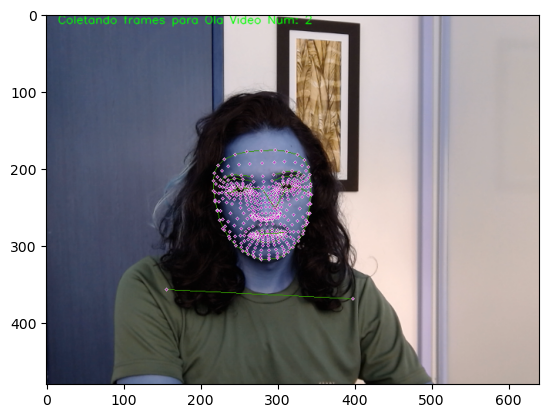

In [148]:
plt.imshow(image)

In [149]:
plt.imshow(prob_viz(res, actions,image,colors))

TypeError: only length-1 arrays can be converted to Python scalars

In [151]:
# 1. New detection variables
sequence, sentence, predictions = [], [], []

threshold = 0.5

cap = cv2.VideoCapture(0)
# Set mediapipe model 
with mp_holistic.Holistic(min_detection_confidence=0.5, min_tracking_confidence=0.5) as holistic:
    while cap.isOpened():

        # Read feed
        ret, frame = cap.read()

        # Make detections
        image, results = mediapipe_detection(frame, holistic)
        print(results)
        
        # Draw landmarks
        draw_styled_landmarks(image, results)
        
        # 2. Prediction logic
        keypoints = extract_keypoints(results)
        sequence.append(keypoints)
        sequence = sequence[-30:]
        
        if len(sequence) == 30:
            res = model.predict(np.expand_dims(sequence, axis=0))[0]
            print(actions[np.argmax(res)])
            predictions.append(np.argmax(res))
            
            
        #3. Viz logic
            if np.unique(predictions[-10:])[0]==np.argmax(res): 
                if res[np.argmax(res)] > threshold: 
                    
                    if len(sentence) > 0: 
                        if actions[np.argmax(res)] != sentence[-1]:
                            sentence.append(actions[np.argmax(res)])
                    else:
                        sentence.append(actions[np.argmax(res)])

            if len(sentence) > 5: 
                sentence = sentence[-5:]

            # Viz probabilities
            image = prob_viz(res, actions, image, colors)
            
        cv2.rectangle(image, (0,0), (640, 40), (245, 117, 16), -1)
        cv2.putText(image, ' '.join(sentence), (3,30), 
                       cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2, cv2.LINE_AA)
        
        # Show to screen
        cv2.imshow('OpenCV Feed', image)

        # Break Loop
        if cv2.waitKey(10) & 0xFF == ord('q'):
            break
    cap.release()
    cv2.destroyAllWindows()

<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.soluti

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Ola
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Ola
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Ola
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Ola
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Ola
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Ola
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Ola
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Ola
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Ola
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Ola
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 ━━━━━━

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Ola
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Ola
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Ola
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Ola
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Ola
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Ola
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Ola
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Ola
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Ola
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Ola
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 ━━━━━━

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Ola
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Ola
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Ola
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Ola
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Ola
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Ola
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Ola
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Ola
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Ola
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Ola
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 ━━━━━━

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Ola
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Ola
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Ola
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Ola
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Ola
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Ola
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Ola
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Ola
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Ola
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Ola
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 ━━━━━━

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Obrigado
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Obrigado
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Obrigado
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Obrigado
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Obrigado
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Obrigado
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Obrigado
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Obrigado
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Obrigado
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Ola
<class 'mediapipe.pyth

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Ola
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Ola
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Ola
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Ola
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Ola
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Ola
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Ola
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Ola
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Ola
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Ola
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 ━━━━━━

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Ola
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Ola
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Ola
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Ola
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Ola
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Ola
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Ola
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
Ola
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
Ola
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Ola
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 ━━━━━━